# Functional Connectivity Analysis with Nilearn

This script closely follows [this example](https://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html) provided through the Nilearn tutorials site.

In [102]:
from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn import cluster, metrics
import pandas as pd
import numpy as np
import os

### The Schaefer Local-Global Parcellation

The Schaefer 2018 parcellation is available from the [CBIG GitHub Repo](https://github.com/ThomasYeoLab/CBIG/tree/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal).

Atlas ROIs are located in nifti image (4D) at: /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


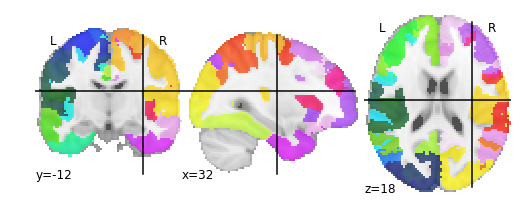

In [155]:
from nilearn import datasets
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2, data_dir='/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer')
atlas_filename = dataset.maps
labels = dataset.labels

print('Atlas ROIs are located in nifti image (4D) at: %s' % atlas_filename)  
from nilearn import plotting
plotting.plot_roi(atlas_filename)

In [114]:
import numpy as np
schaefer_coords = np.loadtxt('data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.Centroid_RAS.csv', delimiter = ',', skiprows=2, usecols=(2,3,4))
schaefer_coords = tuple(map(tuple, schaefer_coords))
schaefer_coords[:5]


((-36.0, -62.0, -16.0),
 (-24.0, -72.0, -10.0),
 (-36.0, -82.0, -16.0),
 (-16.0, -86.0, -16.0),
 (-24.0, -96.0, -12.0))

### Load task data  
Comparing task to rest.

Right now, I'm only using the second run of MemMatch for testing and because I'm hoping the second run is less sensitive to warm-up effects and memory deterioration from elapsed time.

In [85]:
task = 'MemMatch2'

In [86]:
from nipype.interfaces.io import DataFinder

data_dir = '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep'
os.path.isdir(data_dir)

df = DataFinder()
df.inputs.root_paths = data_dir
df.inputs.match_regex = ('%s.+preproc_bold.nii.gz' % task)
df_result = df.run()
fmri_filenames = df_result.outputs.out_paths

conf = DataFinder()
conf.inputs.root_paths = data_dir
conf.inputs.match_regex = ('%s.+regressors.tsv' % task)
conf_result = conf.run()
conf_filenames = conf_result.outputs.out_paths

df = DataFinder()
df.inputs.root_paths = data_dir
df.inputs.match_regex = ('%s.+events.tsv' % task)
df_result = df.run()
event_filenames = df_result.outputs.out_paths

In [88]:
print(fmri_filenames[:5])

['/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


In [101]:
conf_cols = ['csf', 'white_matter', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']


           csf  white_matter   trans_x   trans_y   trans_z     rot_x  \
0  8031.375844   8379.825173  0.000633  0.039057 -0.115080  0.000593   
1  7981.889475   8368.319881  0.001150  0.055397 -0.083406  0.000616   
2  8015.160558   8385.123486 -0.001534  0.017924 -0.109125  0.000551   
3  7983.707895   8369.842660  0.000236  0.065380 -0.102090  0.000801   
4  8007.175827   8368.867827 -0.000638  0.015684 -0.112100  0.000277   

      rot_y     rot_z  
0 -0.000078  0.000110  
1  0.000043  0.000000  
2 -0.000148  0.000000  
3 -0.000017  0.000141  
4 -0.000180  0.000000  


### Extract timeseries
I'm detrending the data and applying a bandpass filter from 0.08 to 0.1 Hz. Timeseries are organized into an array with all subjects (pooled_subjects), as well as by age group (oa_subjects, ya_subjects).

Running this for the whole dataset will take some time, so take a coffee break :)

In [103]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, detrend=True, verbose=5, low_pass=0.1, high_pass=0.08, t_r=1.5)

oa_subjects = []
ya_subjects = []
pooled_subjects = []
oa_list = []
ya_list = []
for fmri_file, confound_file in zip(fmri_filenames, conf_filenames):
    time_series = masker.fit_transform(fmri_file, confounds=pd.read_csv(confound_file, sep = '\t', usecols = conf_cols).values) #change to use motion regressors later
    pooled_subjects.append(time_series)
    partic = fmri_file.split('sub-',1)[1]
    partic = partic[0:5]
    if int(partic) >= 40000:
        oa_subjects.append(time_series)
        oa_list.append(partic)
    else:
        ya_subjects.append(time_series)
        ya_list.append(partic)
    print('Data has {0} OA subjects.'.format(len(oa_subjects)))
    print('Data has {0} YA subjects.'.format(len(ya_subjects)))

np.save('data/%s_oa_subjects' % task, oa_subjects)
np.save('data/%s_ya_subjects' % task, ya_subjects)

np.save('data/%s_oa_list' % task, oa_list)
np.save('data/%s_ya_list' % task, ya_list)

[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Resampling labels
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30004/func/sub-30004_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 1 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30008/func/sub-30008_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 2 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30009/func/sub-30009_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 3 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30012/func/sub-30012_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 4 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30015/func/sub-30015_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 5 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30019/func/sub-30019_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 6 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30020/func/sub-30020_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 7 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30023/func/sub-30023_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 8 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30040/func/sub-30040_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 9 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30057/func/sub-30057_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 10 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30064/func/sub-30064_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 11 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30066/func/sub-30066_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 12 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30069/func/sub-30069_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 13 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30074/func/sub-30074_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 14 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30085/func/sub-30085_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 15 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30088/func/sub-30088_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 16 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30091/func/sub-30091_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 17 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30095/func/sub-30095_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 18 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30096/func/sub-30096_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 19 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30105/func/sub-30105_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 20 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30116/func/sub-30116_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 21 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30118/func/sub-30118_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 22 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30119/func/sub-30119_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 23 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30128/func/sub-30128_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 24 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30181/func/sub-30181_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 25 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30217/func/sub-30217_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 26 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30227/func/sub-30227_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 27 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30236/func/sub-30236_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 28 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30242/func/sub-30242_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 29 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30274/func/sub-30274_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 30 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30330/func/sub-30330_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 31 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30346/func/sub-30346_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 32 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30400/func/sub-30400_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 33 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30403/func/sub-30403_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 34 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30412/func/sub-30412_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 35 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30426/func/sub-30426_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 36 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30432/func/sub-30432_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 37 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30466/func/sub-30466_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 38 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30469/func/sub-30469_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 39 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30476/func/sub-30476_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 40 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30478/func/sub-30478_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 41 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30568/func/sub-30568_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 42 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30570/func/sub-30570_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 43 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30581/func/sub-30581_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 44 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-30584/func/sub-30584_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 0 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40160/func/sub-40160_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 1 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40170/func/sub-40170_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 2 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40175/func/sub-40175_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 3 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40288/func/sub-40288_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 4 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40351/func/sub-40351_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 5 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40490/func/sub-40490_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 6 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40496/func/sub-40496_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 7 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40500/func/sub-40500_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 8 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40512/func/sub-40512_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 9 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40515/func/sub-40515_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 10 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40516/func/sub-40516_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 11 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40519/func/sub-40519_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 12 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40520/func/sub-40520_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 13 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40522/func/sub-40522_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 14 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40524/func/sub-40524_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 15 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40547/func/sub-40547_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 16 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40550/func/sub-40550_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 17 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40564/func/sub-40564_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 18 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40601/func/sub-40601_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 19 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40608/func/sub-40608_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 20 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40615/func/sub-40615_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 21 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40619/func/sub-40619_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 22 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40623/func/sub-40623_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 23 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40629/func/sub-40629_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 24 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40638/func/sub-40638_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 25 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40650/func/sub-40650_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 26 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40655/func/sub-40655_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 27 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40656/func/sub-40656_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 28 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40658/func/sub-40658_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 29 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40664/func/sub-40664_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 30 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40665/func/sub-40665_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 31 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40672/func/sub-40672_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 32 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40685/func/sub-40685_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 33 OA subjects.
Data has 45 YA subjects.
[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40694/func/sub-40694_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 34 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40720/func/sub-40720_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 35 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40728/func/sub-40728_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 36 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40730/func/sub-40730_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 37 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40738/func/sub-40738_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 38 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40750/func/sub-40750_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 39 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40758/func/sub-40758_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 40 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40767/func/sub-40767_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 41 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40769/func/sub-40769_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 42 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40777/func/sub-40777_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 43 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40778/func/sub-40778_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
Data has 44 OA subjects.
Data has 45 YA subjects.


/usr/local/lib/python3.7/site-packages/scipy-1.1.0-py3.7-macosx-10.13-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


[NiftiLabelsMasker.fit_transform] loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/schaefer/schaefer_2018/Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Volumes/schnyer/Aging_DecMem/Scan_Data/BIDS/derivatives/fmriprep/sub-40779/func/sub-40779_task-MemMatch2_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


ValueError: Confound signal has an incorrect length

In [259]:
oa_subjects = np.load('data/%s_oa_subjects.npy' % task)
ya_subjects = np.load('data/%s_ya_subjects.npy' % task)

### Get task performance from events files

In [ ]:
import pandas as pd
import numpy as np

ya_task_results = []
oa_task_results = []

for event_file in event_filenames:
    partic = event_file.split('sub-')[1]
    partic = partic[0:5]
    events = pd.read_csv(event_file, sep = '\t')
    correct = np.where(events['answer'] == events['Response'], 1, 0).sum()
    n_trials = len(events)
    accuracy = correct/n_trials
    rt = events['Resp_time'].mean()
    if int(partic) < 40000:
        ya_task_results.append([partic, accuracy, rt])
    else:
        oa_task_results.append([partic, accuracy, rt])
    print('task results for %d OA subjects' % len(oa_task_results))
    print('task results for %d YA subjects' % len(ya_task_results))
    
np.save('data/%s_oa_task_results' % task, oa_task_results)
np.save('data/%s_ya_task_results' % task, ya_task_results)   

### Calculate functional connectivity using full correlation

In [106]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

correlation_matrices_oa = correlation_measure.fit_transform(oa_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of OA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_oa.shape))

mean_correlation_matrix_oa = correlation_measure.mean_
print('Mean correlation OA has shape {0}.'.format(mean_correlation_matrix_oa.shape))

Correlations of OA patients are stacked in an array of shape (44, 400, 400)
Mean correlation OA has shape (400, 400).


In [107]:
np.save('data/%s_correlation_matrices_oa' % task, correlation_matrices_oa)

In [108]:
correlation_matrices_ya = correlation_measure.fit_transform(ya_subjects)

# All individual coefficients are stacked in a unique 2D matrix.
print('Correlations of YA patients are stacked in an array of shape {0}'
      .format(correlation_matrices_ya.shape))

mean_correlation_matrix_ya = correlation_measure.mean_
print('Mean correlation YA has shape {0}.'.format(mean_correlation_matrix_ya.shape))

Correlations of YA patients are stacked in an array of shape (45, 400, 400)
Mean correlation YA has shape (400, 400).


In [109]:
np.save('data/%s_correlation_matrices_ya' % task, correlation_matrices_ya)

### Plot correlation matrices for a handful of subjects

In [4]:
correlation_matrices_oa = np.load('data/correlation_matrices_oa.npy')
correlation_matrices_ya = np.load('data/correlation_matrices_ya.npy')

47


In [110]:
import matplotlib.pylab as plt

def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

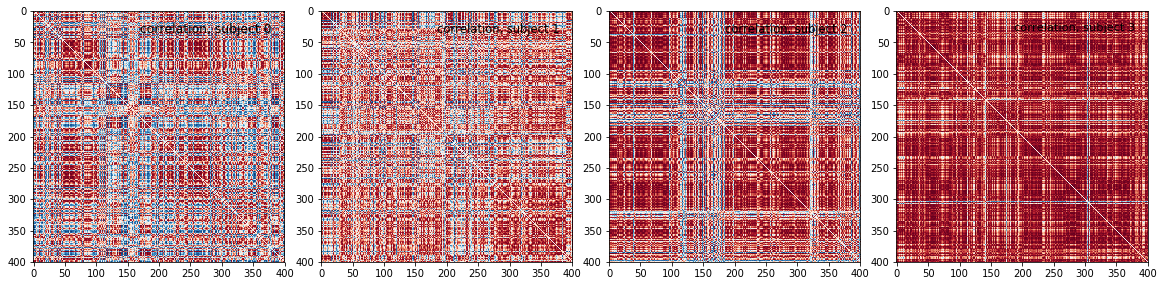

In [111]:
plot_matrices(correlation_matrices_oa[:4], 'correlation')

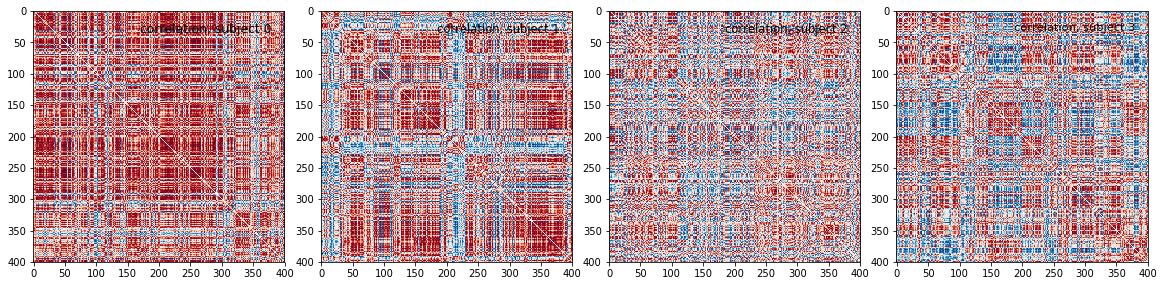

In [112]:
plot_matrices(correlation_matrices_ya[:4], 'correlation')

### Mean Group Correlation Matrices

**Older Adults**

In [126]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=None, filternorm=1, filterrad=4.0, imlim=None, resample=None, url=None, *, data=None, **kwargs)>

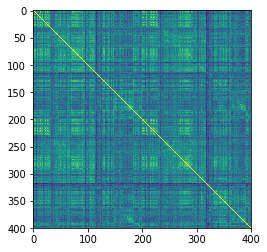

In [128]:
plt.imshow(mean_correlation_matrix_oa)

**Young Adults**

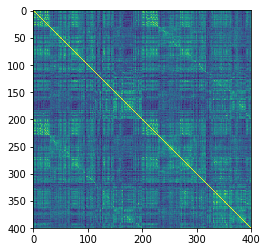

In [124]:
plt.imshow(mean_correlation_matrix_ya)

### Visualize group mean correlation matrices on glass brain

Another good time for a coffee break if not using the edge_threshold option.

It's really hard to see the edges since I can't find a way to only show nodes with significant edges.

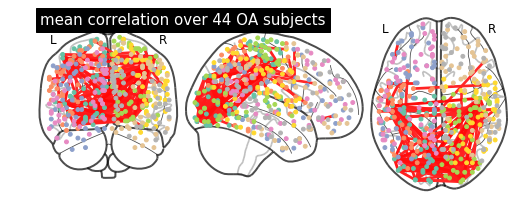

In [139]:
from nilearn import plotting

plotting.plot_connectome(mean_correlation_matrix_oa, schaefer_coords, \
                         title='mean correlation over {0} OA subjects'.format(len(correlation_matrices_oa)), \
                                                                             edge_threshold=.75, \
                                                                             node_size=15)


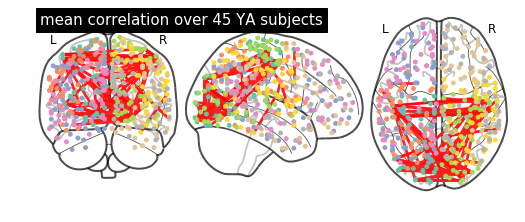

In [136]:
plotting.plot_connectome(mean_correlation_matrix_ya, schaefer_coords, title='mean correlation over {0} YA subjects'.format(len(correlation_matrices_ya)), \
                         edge_threshold='75%',
                        node_size=15)


### Use the Network-Based Statistic to analyze group functional connectivity differences

Read more about NBS in [Zalesky (2010)](10.1016/j.neuroimage.2010.06.041).

This uses the [Brain Connectivity Toolbox for Python](https://github.com/aestrivex/bctpy).

    x : NxNxP np.ndarray
        matrix representing the first population with P subjects. must be
        symmetric.
    y : NxNxQ np.ndarray
        matrix representing the second population with Q subjects. Q need not
        equal P. must be symmetric.
    thresh : float
        minimum t-value used as threshold
    k : int
        number of permutations used to estimate the empirical null 
        distribution
    tail : {'left', 'right', 'both'}
        enables specification of particular alternative hypothesis
        'left' : mean population of X < mean population of Y
        'right' : mean population of Y < mean population of X
        'both' : means are unequal (default)

In [140]:
X = correlation_matrices_ya.reshape((400, 400, len(correlation_matrices_ya)))
Y = correlation_matrices_oa.reshape((400, 400, len(correlation_matrices_oa)))

In [152]:
from bct import nbs

pval, adj, null = nbs.nbs_bct(X, Y, thresh=20, k=3, tail='right', paired=False, verbose=False)

max component size is 13
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


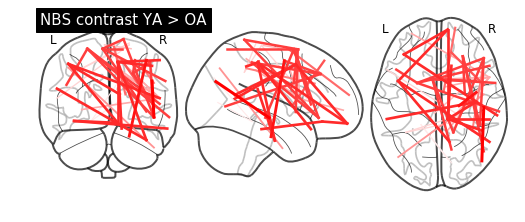

In [153]:
from nilearn import plotting
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast YA > OA', node_size=0)

In [147]:
pval, adj, null = nbs.nbs_bct(X, Y, thresh=20.0, k=3, tail='left', paired=False, verbose=False)

max component size is 18
estimating null distribution with 3 permutations
permutation 0 of 3.  p-value so far is 0.000
permutation 2 of 3.  p-value so far is 0.000


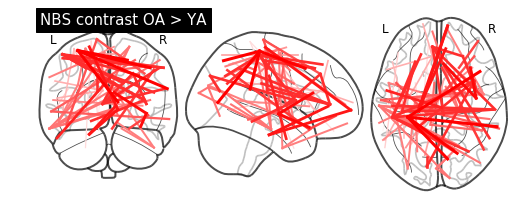

In [150]:
plotting.plot_connectome(adj, schaefer_coords, title='NBS contrast OA > YA', node_size=0)

In [255]:
dmn_mask = np.r_[148:200,361:400]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(91, 45)

In [250]:
dmn_mask = np.r_[148:200,361:400]
dmn_mask

array([148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373,
       374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386,
       387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399])

### BCT graph metrics by age group

In [256]:
from bct import algorithms
import pandas as pd

bct_data_oa = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity'))
for sub in range(0,np.ma.size(Y, 2)):
    thresh_mat = bct.threshold_proportional(Y[:,:,sub], .20)
    ge = algorithms.efficiency_wei(thresh_mat, local = False)
    cc = algorithms.clustering_coef_wu(thresh_mat).mean()
    Ci, Q = algorithms.modularity_und(thresh_mat)
    bct_data_oa = bct_data_oa.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q}, index=[0]), ignore_index=True)

print(bct_data_oa[:5])
np.save('data/%s_bct_oa' % task, bct_data_oa)


   efficiency_global  clustering_coef  modularity
0           0.553006         0.266077    0.107073
1           0.553958         0.272479    0.111676
2           0.553539         0.264427    0.108047
3           0.554260         0.274429    0.105283
4           0.552647         0.266062    0.109620


In [257]:
from bct import algorithms, other
import pandas as pd

thresh_mat = []
bct_data_ya = pd.DataFrame(columns = ('efficiency_global', 'clustering_coef', 'modularity'))
for sub in range(0,np.ma.size(X, 2)):
    thresh_mat = bct.threshold_proportional(X[:,:,sub], .20)
    ge = algorithms.efficiency_wei(thresh_mat, local = False)
    cc = algorithms.clustering_coef_wu(thresh_mat).mean()
    Ci, Q = algorithms.modularity_und(thresh_mat)
    bct_data_ya = bct_data_ya.append(pd.DataFrame({'efficiency_global': ge, 'clustering_coef': cc, 'modularity': Q}, index=[0]), ignore_index=True)

print(bct_data_ya[:5])
np.save('data/%s_bct_ya' % task, bct_data_ya)

   efficiency_global  clustering_coef  modularity
0           0.547587         0.245272    0.063934
1           0.547266         0.235230    0.061066
2           0.547275         0.238495    0.062311
3           0.547390         0.240557    0.061512
4           0.547835         0.240157    0.057103


In [258]:
from scipy import stats

t, p = stats.ttest_ind(bct_data_ya, bct_data_oa, equal_var=False)
print('global efficiency, clustering, modularity \n t-statistics: %s \n p-values: %s' %(t, p))

global efficiency, clustering, modularity 
 t-statistics: [-57.74194228 -34.19248944 -79.18750994] 
 p-values: [9.18498855e-68 1.66804492e-49 1.67242603e-82]


{'bodies': [<matplotlib.collections.PolyCollection at 0x11ebbfe80>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x11ec14b00>,
 'cmins': <matplotlib.collections.LineCollection at 0x11ebbf5c0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11ebbf4a8>}

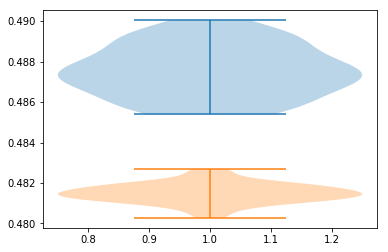

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.violinplot(bct_data_ya['efficiency_global'])
plt.violinplot(bct_data_oa['efficiency_global'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e9b9898>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e83cda0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e9b9550>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e9b9320>}

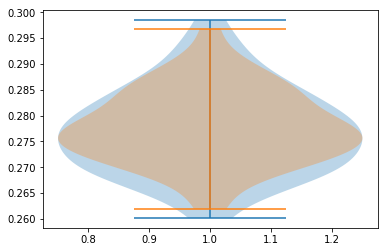

In [82]:
plt.violinplot(bct_data_ya['clustering_coef'])
plt.violinplot(bct_data_oa['clustering_coef'])

{'bodies': [<matplotlib.collections.PolyCollection at 0x11e0446a0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x11e83ce80>,
 'cmins': <matplotlib.collections.LineCollection at 0x11e044128>,
 'cbars': <matplotlib.collections.LineCollection at 0x11e044160>}

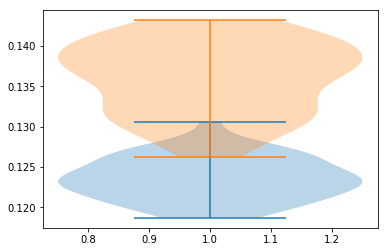

In [83]:
plt.violinplot(bct_data_ya['modularity'])
plt.violinplot(bct_data_oa['modularity'])